221


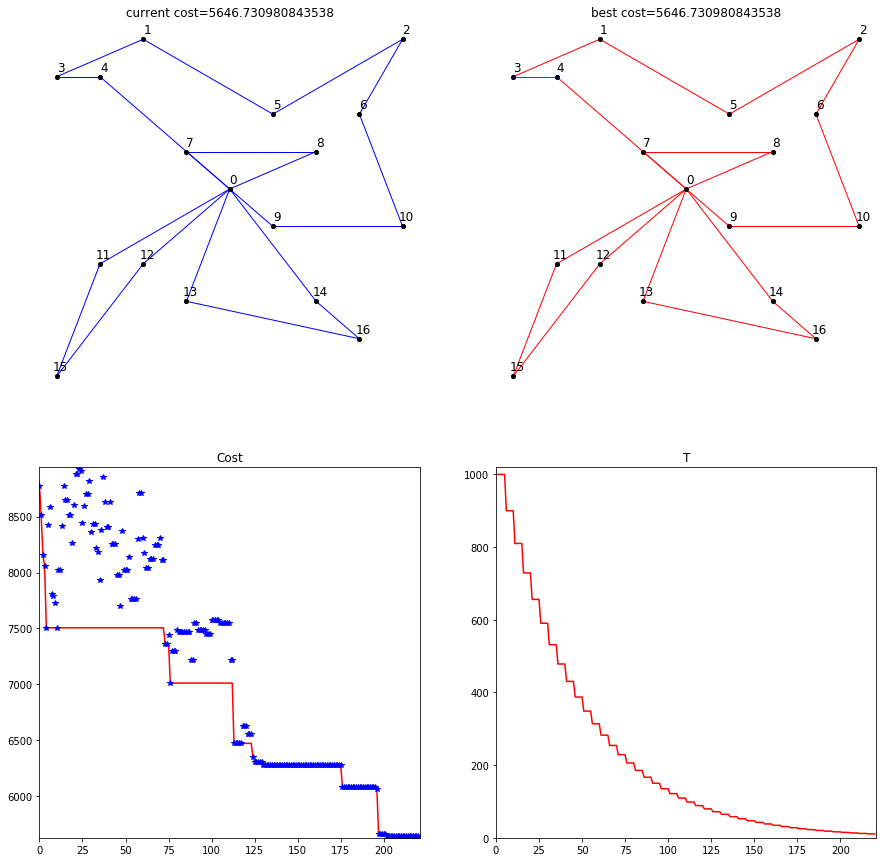

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import copy
from matplotlib import rc

def Cost_node(data,i,j):
    (a_x,a_y) = data['locations'][i]
    (b_x,b_y) = data['locations'][j]
    return np.sqrt((b_x-a_x)**2+(b_y-a_y)**2) 

def COST_Tour(arr,data):
    cost=0
#     print(arr)
    for i in range(len(arr)-1):
        cost+= Cost_node(data,arr[i],arr[i+1])
    return cost

def COST_Solution(s):
    cost=0
    for i in range(len(s) ):
        cost+= s[i][2]
    return cost

def ACCEPT(costCurrent,costNew,T):
    return np.exp((costCurrent - costNew)/T)> np.random.rand()
    
def Remove_node(s, tour,node_pos,data):
#     print(s[tour])
    node = s[tour][0][node_pos]
    
    node_1=s[tour][0][node_pos-1]
    node_2=s[tour][0][node_pos+1]
    
    cost1 = Cost_node(data,node_1,node)+ Cost_node(data,node,node_2)
    cost2 = Cost_node(data,node_1,node_2) 

    cap = s[tour][1] -data['demands'][node]
    c =s[tour][2]-cost1+cost2
    
    arr= s[tour][0]     
    del arr[node_pos]
    
    s[tour]=(arr,cap,c)
    

        
def Insert_node(s,node, tour,point):
    node_1=s[tour][0][point-1]
    node_2=s[tour][0][point]

    cost1 = Cost_node(data,node_1,node)+ Cost_node(data,node,node_2)
    cost2 = Cost_node(data,node_1,node_2)
    
    s[tour][0].insert(point, node)
    arr= s[tour][0] 
    cap =  s[tour][1] +  data['demands'][node]
    c= s[tour][2] + cost1 -cost2
    
    s[tour]=(arr,cap,c)
#     print(s[tour])

def NEIGHBOR_VRP(s,data):
    fea= False 
    while not fea:
        tour_a = np.random.randint(len(s))
        while len(s[tour_a][0])<=3:
            tour_a = np.random.randint(len(s))
        pos_a = np.random.randint(len(s[tour_a][0])-2)+1
        tour_b = np.random.randint(len(s)) 
        if tour_a == tour_b and len(s[tour_a][0])>3:
            point_b = pos_a 
            while point_b == pos_a :
                point_b = np.random.randint(len(s[tour_b][0])-2)+1 
        else:
            point_b = np.random.randint(len(s[tour_b][0])-1)+1    
        
        # remove node_a
        sNew = copy.deepcopy(s)
        temp_node = sNew[tour_a][0][pos_a]
        Remove_node(sNew, tour_a,pos_a, data)
    
        # insert into position tour_b point_b
        Insert_node(sNew,temp_node, tour_b,point_b)
        if sNew[tour_b][1]< data['vehicle_capacities'][tour_b]:
            fea=True
    
    return sNew

def Capacity(arr,i,j,data):
    cap = 0
    for k in arr:
        cap += data['demands'][k]
    return cap+ data['demands'][i] 
       
                                  
# s is the solution with all tours, each tour has a sequence, capacity and cost
def Initial_VRP(data):
    s=[]
    used =[False]* data['num_locations']
    for j in range(data['num_vehicles']):
        arr=[]
        cap = 0
        for i in range(1,data['num_locations']):
            if used[i] == False:
                if cap + data['demands'][i]  <= data['vehicle_capacities'][j]:
                    arr += [i]
                    cap += data['demands'][i]
                    used[i] =True
        
        arr = [0] + arr +[0]
        c = COST_Tour(arr, data)
        s.append((arr, cap,c))   
    return s
    
def SA_VRP(data):
    T = 1000
    T_0 = 10
    alpha = 0.9
    IterL = 5
    sCurrent = Initial_VRP(data)
    sBest = sCurrent
    costCurrent = COST_Solution(sCurrent)
    costBest = costCurrent
    num = 0
    i = 0
    record = []
    record.append([num, sCurrent, sBest, costCurrent, costBest,T])
    while T > T_0:
        while i < IterL:
            sNew = NEIGHBOR_VRP(sCurrent,data)
            costNew =  COST_Solution(sNew)
            if costNew <costCurrent:
                costCurrent = costNew
                sCurrent = sNew    
                if costNew < costBest:
                    costBest = copy.deepcopy(costNew)
                    sBest = copy.deepcopy(sNew)
            elif ACCEPT(costCurrent, costNew, T):
                costCurrent = costNew
                sCurrent = sNew
            i += 1
            num +=1 
            record.append([num, sCurrent, sBest, costCurrent, costBest,T])
        i= 0
        T = T*alpha
    return record

class UpdateDist:
    def __init__(self, ax1,ax2,ax3,ax4, record,g):
        self.g = g
        self.node_positions = {node[0]: (node[1]['attr_dict']['X'], -node[1]['attr_dict']['Y']) for node in list(g.nodes(data=True))}
        self.record = record

        self.ax1 = ax1
        self.ax2 = ax2
       
        self.x2= np.array([0])
        self.y2= np.array([0])
        self.line2, = ax3.plot([], [], 'r-')
        
        self.x3= np.array([0])
        self.y3= np.array([0])
        self.line3, = ax3.plot([], [], 'b*')
        self.ax3= ax3
        self.ax3.set_xlim(0,len(record))
        temp = [a[3] for a in record]
        self.ax3.set_ylim(min(temp)-20, max(temp)+20)
        self.ax3.set_title("Cost")
        
        self.x4= np.array([0])
        self.y4= np.array([0])
        self.line4, = ax4.plot([], [], 'r-')
        self.ax4= ax4
        self.ax4.set_xlim(0,len(record))
        temp = [a[5] for a in record]
        self.ax4.set_ylim(0, max(temp)+20)
        self.ax4.set_title("T")



    def __call__(self, i):


        # remove all nodes 
        self.ax1.clear()
        self.ax2.clear()
        self.g.remove_edges_from(list(self.g.edges()))

        # current 
        s = self.record[i][1]
        for k in range(len(s)):
            for t in range(len(s[k][0])-1):
                self.g.add_edge(s[k][0][t], s[k][0][t+1])

        edge_colors = ["blue"]*len(self.g.edges)
        self.ax1.set_title( "current cost="+ str(self.record[i][3]))
        nx.draw(self.g, pos=self.node_positions,  edge_color=edge_colors, node_size=len(g.nodes),ax=self.ax1, node_color='black')
        
#         # best 
        self.g.remove_edges_from(list(self.g.edges()))
        s = self.record[i][2]
        for k in range(len(s)):
            for t in range(len(s[k][0])-1):
                self.g.add_edge(s[k][0][t], s[k][0][t+1])
        edge_colors = ["red"]*len(self.g.edges)
        self.ax2.set_title("best cost="+ str(self.record[i][4]))
        nx.draw(self.g, pos=self.node_positions,  edge_color=edge_colors, node_size=len(g.nodes),ax=self.ax2, node_color='black')
        node_labels = {}
        for ii in range(len(self.g.nodes(data=True))):
#             aaa=str( list(self.g.nodes(data=True))[ii][0])+" ("+str(list(self.g.nodes(data=True))[ii][1]['attr_dict']['X'] )+", " +str(list(self.g.nodes(data=True))[ii][1]['attr_dict']['Y'] )+")"
            aaa=str( list(self.g.nodes(data=True))[ii][0])
            node_labels[ii] = aaa
            
        text_position = copy.deepcopy(self.node_positions)
        for node in list(text_position.keys()):
            (x,y)=text_position[node]
            text_position[node]=(x+10,y+20)

        nx.draw_networkx_labels(g, text_position,ax=self.ax2,  labels=node_labels)
        nx.draw_networkx_labels(g, text_position,ax=self.ax1,  labels=node_labels)

        if i ==0 :
            self.x2=np.array(i)
            self.y2=np.array(self.record[i][4])
            self.x3=np.array(i)
            self.y3=np.array(self.record[i][3])
            self.x4=np.array(i)
            self.y4=np.array(self.record[i][5])
        else:
            self.x2=np.append(self.x2, i)
            self.y2=np.append(self.y2, self.record[i][4])
            self.x3=np.append(self.x3, i)
            self.y3=np.append(self.y3, self.record[i][3])
            self.x4=np.append(self.x4, i)
            self.y4=np.append(self.y4, self.record[i][5])

        
        self.line2.set_data(self.x2, self.y2)
        self.line3.set_data(self.x3, self.y3)
        self.line4.set_data(self.x4, self.y4)
        
        return self.line2, self.line3, self.line4,
    
def create_data_model():
    data = {}
      # Locations in block units
    locations =[(4, 4), # depot
           (2, 0), (8, 0), # locations to visit
           (0, 1), (1, 1),
           (5, 2), (7, 2),
           (3, 3), (6, 3),
           (5, 5), (8, 5),
           (1, 6), (2, 6),
           (3, 7), (6, 7),
           (0, 9), (7, 8)]
    demands=[0, # depot
             1, 1, # row 0
             2, 4,
             2, 4,
             8, 8,
             1, 2,
             1, 2,
             4, 4,
             8, 8]

    capacities = [18,18,18,18]

  # Multiply coordinates in block units by the dimensions of an average city block, 114m x 80m,
  # to get location coordinates.
    data["locations"] = [(l[0] * 114, l[1] * 80) for l in locations]
    data["num_locations"] = len(data["locations"])
    data["num_vehicles"] = len(capacities)
    data["depot"] = 0
    data["demands"] = demands
    data["vehicle_capacities"] = capacities
    return data

def Initial_Graph(data):
    g = nx.Graph()
    for i in range(len(data['locations'])):
        (x,y) = data['locations'][i]
        g.add_node(i,attr_dict={"X":x,"Y":y})
    return g

np.random.seed(10)
num = 20
data = create_data_model()
# print(data)


g = Initial_Graph(data)
# Initial_VRP(data)
record = SA_VRP(data)

print(len(record))
# print(record[0])

fig,axs = plt.subplots(2,2)
fig.set_figheight(15)
fig.set_figwidth(15)

ud = UpdateDist(axs[0][0],axs[0][1],axs[1][0],axs[1][1],record, g)
anim = FuncAnimation(fig, ud, frames=len(record), interval=50, blit=True)
anim.save('./CVRP_SA.gif', writer='imagemagick', fps=1)
rc('animation', html='html5')
anim
